# ParSNIP SNCosmo MCMC demo

This notebook demonstrates the SNCosmo interface to ParSNIP. We use variational inference in ParSNIP to estimate the parameters for a given light curve and produce an SNCosmo model that approximately fits a light curve. We then use SNCosmo to run MCMC and evaluate the true posterior over all of the parameters.

# Load the datasets and models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sncosmo
from astropy.table import Table
import corner
import lcdata
import parsnip

In [2]:
%%time
# PLAsTiCC

# Load the PLAsTiCC dataset
plasticc_dataset = parsnip.load_dataset('../data/plasticc_combined.h5', in_memory=False)

# Load the PLAsTiCC model
plasticc_model = parsnip.load_model('../models/parsnip_plasticc.pt')

Parsing 'plasticc_combined.h5' as PLAsTiCC dataset...
CPU times: user 848 ms, sys: 129 ms, total: 977 ms
Wall time: 1.01 s


# Run MCMC to get posterior distributions

In [3]:
def gaussian(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

def mcmc_posterior(lc, nwalkers=20, **kwargs):
    lc = parsnip.preprocess_light_curve(lc, plasticc_model.settings)
    lc = lcdata.to_sncosmo(lc)

    # Add the error floor so that we can compare directly to the results from running
    # through our model.
    scale = lc.meta['parsnip_scale']
    lc['fluxerr'] = np.sqrt(lc['fluxerr']**2 + (scale * plasticc_model.settings['error_floor'])**2)

    # Do variational inference to predict the model parameters, and instantiate an SNCosmo model
    # with those parameters.
    sncosmo_model = plasticc_model.predict_sncosmo(lc)

    # Include the priors on the latent variables.
    priors = {
        's1': gaussian,
        's2': gaussian,
        's3': gaussian,
    }

    parameters = ['t0', 'amplitude', 'color', 's1', 's2', 's3']

    # Run MCMC to evaluate the full posterior of a light curve.
    emcee_result, fitted_model = sncosmo.mcmc_lc(
        lc,
        sncosmo_model,
        parameters,
        priors=priors,
        nwalkers=nwalkers,
        **kwargs,
    )

    # Show the fitted light curve
    parsnip.plot_light_curve(lc, plasticc_model, sncosmo_model=fitted_model)
    plt.xlim(-100, 100)

    # Make a corner plot of the results.
    corner.corner(
        emcee_result['samples'],
        labels=['Reference Time', 'Amplitude', 'Color', '$s_1$', '$s_2$', '$s_3$']
    )
    
    # Compare the uncertainties from the predictions.
    lc_predictions = plasticc_model.predict(lc)
    parsnip_uncertainties = [
        lc_predictions['reference_time_error'],
        lc_predictions['amplitude_error'] * 10**(-0.4 * 45),
        lc_predictions['color_error'],
        lc_predictions['s1_error'],
        lc_predictions['s2_error'],
        lc_predictions['s3_error'],
    ]

    # Print a comparsion of the model parameters
    tab = Table({
        'Parameter': parameters,
        'ParSNIP prediction': [sncosmo_model[i] for i in parameters],
        'MCMC prediction': [fitted_model[i] for i in parameters],
        'ParSNIP uncertainty': parsnip_uncertainties,
        'MCMC uncertainty': np.sqrt(np.diag(emcee_result['covariance'])),
    })

    return tab

# Examples

## Well-measured, high signal-to-noise light curve

Parameter,ParSNIP prediction,MCMC prediction,ParSNIP uncertainty,MCMC uncertainty
str9,float64,float64,float64,float64
t0,59909.256111647126,59909.42514992693,0.08185817301273346,0.08164587649058327
amplitude,2.1606070995330814e-18,2.1940312486972307e-18,1.1123950593173505e-20,4.859525406395652e-20
color,0.2502595782279968,0.25473948648116035,0.00820726715028286,0.006943637574412321
s1,1.1097044944763184,1.0511811463461174,0.048137567937374115,0.05138775247466954
s2,0.7371637225151062,0.44094387272045743,0.15432776510715485,0.14005744152699154
s3,0.6325616836547852,1.1346522680462072,0.25397568941116333,0.24567339073617


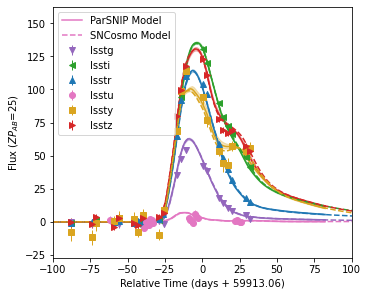

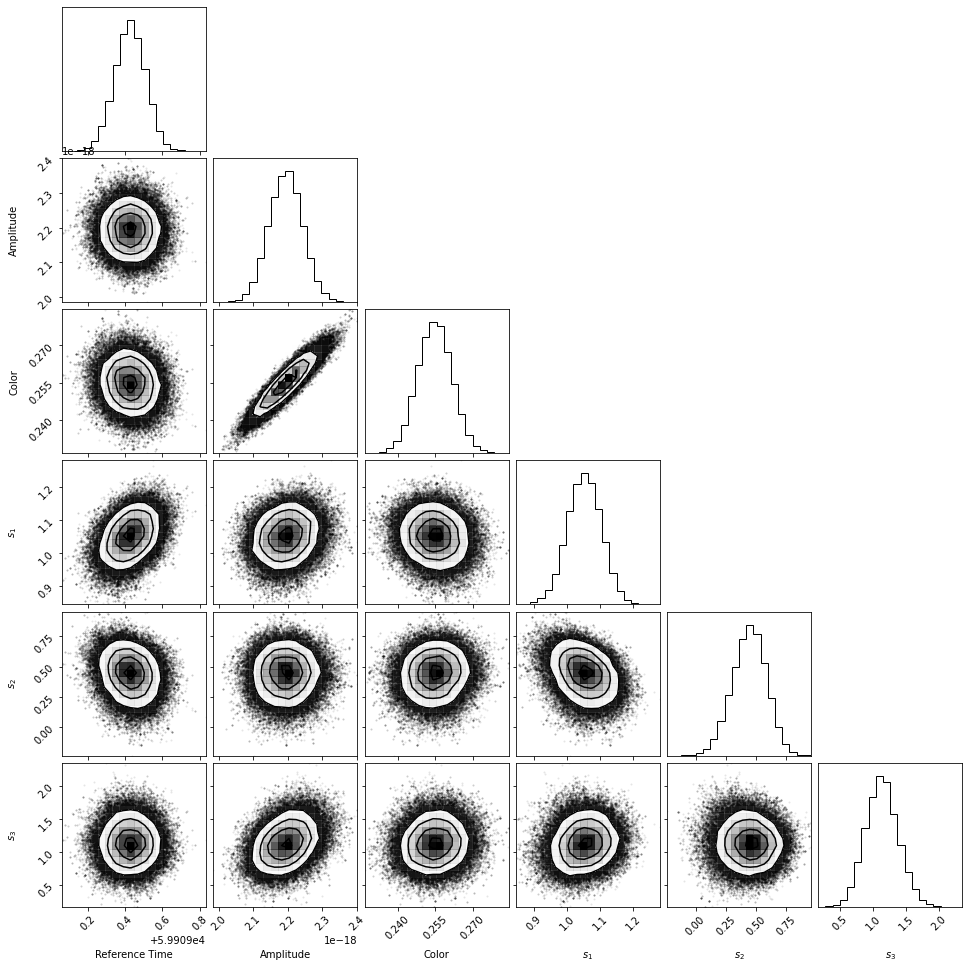

In [4]:
lc = plasticc_dataset.get_lc('PLAsTiCC 000338176')
mcmc_posterior(lc, nsamples=10000)

## Well-measured, lower signal-to-noise light curve

Parameter,ParSNIP prediction,MCMC prediction,ParSNIP uncertainty,MCMC uncertainty
str9,float64,float64,float64,float64
t0,60576.29113850153,60575.916929242296,0.6738516688346863,0.750844534904441
amplitude,1.1329301446676256e-19,1.400976154305103e-19,2.9967748560011387e-21,3.8310008407403477e-20
color,-0.059845466166734695,-0.023445075404783716,0.05081341415643692,0.06717351731857386
s1,0.569058895111084,0.7153507606342063,0.21509672701358795,0.23990841737287016
s2,0.09360089898109436,0.05773239837748849,0.5642963647842407,0.7507660851259649
s3,0.2746187448501587,0.09357501676179525,0.8409980535507202,0.9638642851535394


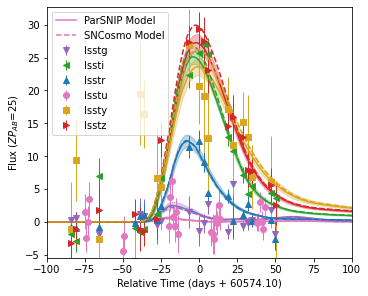

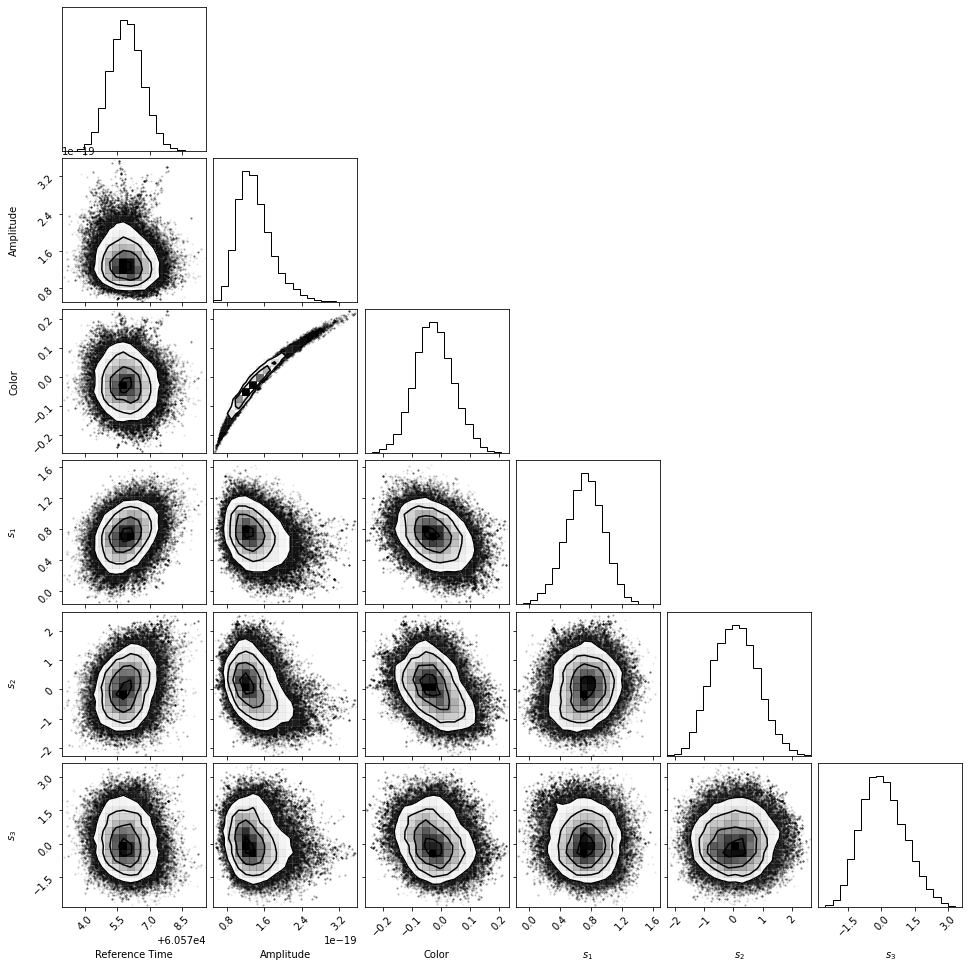

In [5]:
lc = plasticc_dataset.get_lc('PLAsTiCC 000000060')
result = mcmc_posterior(lc, nsamples=10000)
plt.savefig('./figures/mcmc_posterior.pdf')
result

## Partially-measured measured light curve

Parameter,ParSNIP prediction,MCMC prediction,ParSNIP uncertainty,MCMC uncertainty
str9,float64,float64,float64,float64
t0,60324.47453656645,60312.21049478706,3.643660545349121,9.99828482600125
amplitude,7.423008233308793e-20,3.0605077122506587e-19,5.433952901512385e-21,3.0304381045976846e-19
color,-0.053439199924468994,0.07502239680924218,0.13268820941448212,0.22754590102044228
s1,0.8679689168930054,0.49359594744845925,0.44019874930381775,0.4936236001753399
s2,-0.10377611219882965,0.055379125156287345,0.8594914674758911,1.0071749052779913
s3,0.16502375900745392,0.10412631866345853,0.963554322719574,0.8795975842207903


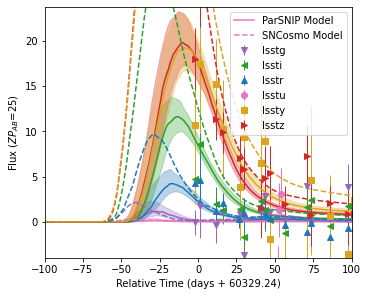

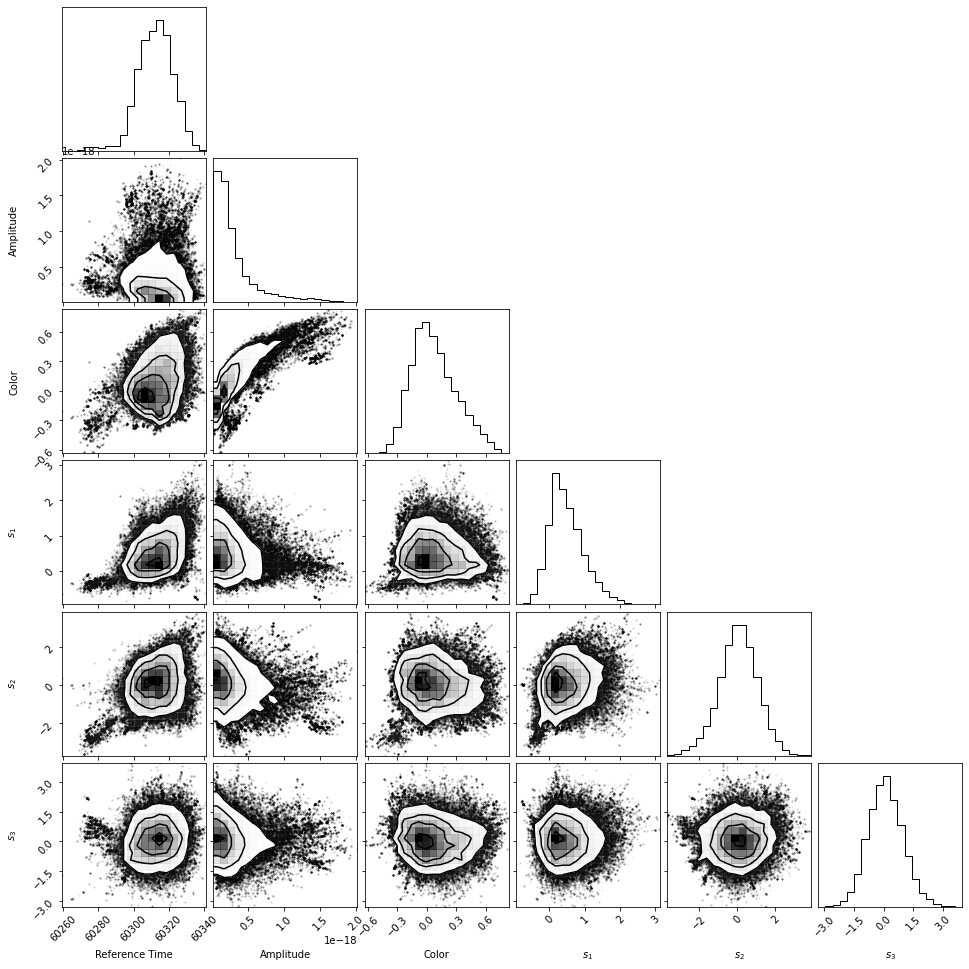

In [7]:
lc = plasticc_dataset.get_lc('PLAsTiCC 000000116')
mcmc_posterior(lc, nsamples=10000)